In [7]:
# This is for RTL, only way it works in nbviewer, please ignore this
from IPython.core.display import HTML
HTML("<style>.jp-RenderedMarkdown { direction: rtl;} .jp-RenderedMarkdown p { text-align: right;}</style>")

# ניתוח סנטימנטלי של תסריטים כבסיס לסיווג ז'אנרים 
**הצעת פרויקט - איתם יוגב**

## מטרת הפרויקט ומוטיבציה &#x202b;

בעיית סיווג


בפרויקט זה ארצה לבצע ניתוח סנטימנטלי 

## sdf

https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')

line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='skip')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='skip')


In [4]:
meta.shape[0]

617

In [4]:
def str_to_list(str: str):
    return str.strip('\'[]').split("\' \'")

max_length = 1400

def get_line_groups(lines: list[str]):
    curr_group = None
    for line in lines:
        if not curr_group:
            curr_group = line
        elif len(curr_group) + len(line) > max_length:
            yield curr_group
        else:
            curr_group = ' '.join([curr_group, line])

def get_lines_text(row):
    try:
        line_texts = [lines.loc[id].text[:max_length] for id in str_to_list(row['line_ids'])]
        if sum([len(s) for s in line_texts]) <= max_length:
            return [' '.join(line_texts)]
        return get_line_groups(line_texts)
    except:
        return None

def get_dialog_texts():
    for i in tqdm(range(len(convos))):
        convo = convos.iloc[i]
        texts = get_lines_text(convo)
        if not texts:
            continue
        for text in texts:
            yield {
                'first_char': convo.first_char,
                'second_char': convo.second_char,
                'movie_id': convo.movie_id,
                'text': text
            }

In [12]:
dialog_texts = pd.DataFrame(get_dialog_texts())

  0%|          | 0/83097 [00:00<?, ?it/s]

In [ ]:
dialog_texts.head()

In [ ]:
maxlen = dialog_texts.text.str.len().max()
long_scene = dialog_texts[dialog_texts['text'].str.len() == maxlen].iloc[0].text

In [ ]:
max_length

In [7]:
from transformers import pipeline
classifier = pipeline("text-classification",
                      model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=None)

In [8]:
def preprocess_subtitle(text: str):
    return text
#   new_text = []
#   for t in text.split():
#     if t.upper() == t:
#       continue
#     new_text.append(t)
#   return " ".join(new_text)

In [9]:
def get_emotion_feats(classifier_res: list[list[dict]]):
  return { x['label']: x['score'] for x in classifier_res[0] }

def get_dialog_emotions(df):
    for i in tqdm(range(df.shape[0])):
        dialog = df.iloc[i]
        try:
          txt = preprocess_subtitle(dialog.text)
          feats = get_emotion_feats(classifier(txt))
          feats['movie_id'] = dialog.movie_id
          feats['text'] = txt
        except:
          print('error, length: ', len(dialog.text))
        yield feats

In [10]:
def get_movie_emots(movie_id):
    return pd.DataFrame(get_dialog_emotions(dialog_texts[dialog_texts['movie_id'] == movie_id]))

In [ ]:
movie_emots = []

for i in tqdm(range(100)):
    movie = meta.iloc[i]
    movie_id = meta.index[i]
    print(movie_id, movie.title, movie.genres)
    emots = get_movie_emots(movie_id)
    movie_emots.append(emots)
    emots.to_pickle('data/emots/' + movie_id)

In [16]:
from math import pi

def get_avg_emots(emots: pd.DataFrame):
    return emots.drop(['text'], axis=1).groupby('movie_id').agg(
        np.average)

def show_spider(data: pd.DataFrame, label_col: str = None):
    categories = (data.drop(label_col, axis=1) if label_col else data).columns.to_list()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.axes.get_yaxis().set_ticklabels([])
    for id, v in data.iterrows():
        values = (v.drop(label_col) if label_col else v).values.tolist()
        values += values[:1]
        label = str(v[label_col]) if label_col else id
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    if len(data) > 1:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

In [17]:
concated_avg = pd.concat([get_avg_emots(e) for e in movie_emots])
normalized = (concated_avg-concated_avg.mean())/concated_avg.std()
normalized['genres'] = meta.loc[normalized.index]['genres'].apply(
    lambda x: str_to_list(x))


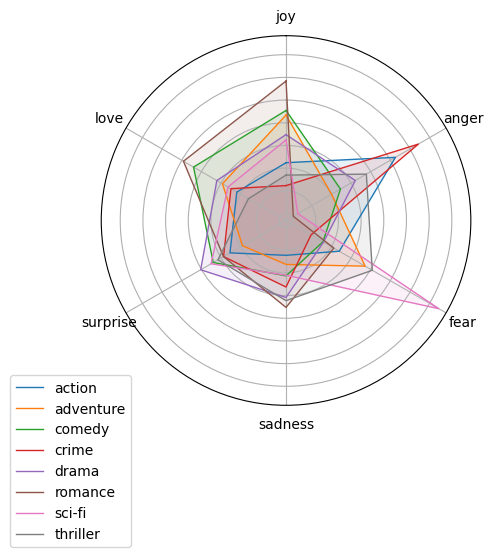

In [28]:
exploded = normalized.explode('genres')
genre_avgs = exploded.groupby('genres').agg(np.average)
genre_counts = exploded.groupby('genres').size()
genre_avgs = genre_avgs[genre_counts[genre_avgs.index] > 18]
show_spider(genre_avgs)
